# Curso Computer Vision

<img src="https://yaelmanuel.com/wp-content/uploads/2021/12/platzi-banner-logo-matematicas.png" width="500px">

---

**Instalar dependencias**

In [ ]:
!pip3 install ultralytics

**Descargar el modelo de Yolo manualmente**

In [ ]:
# !wget https://github.com/ultralytics/assets/releases/download/v8.3.0/yolo11n-seg.pt

**Definir el path del vídeo**

In [18]:
video_path = "../videos/store.mp4"

In [9]:
video_path = "/content/park_detection.avi"

**Arrancar el proceso**

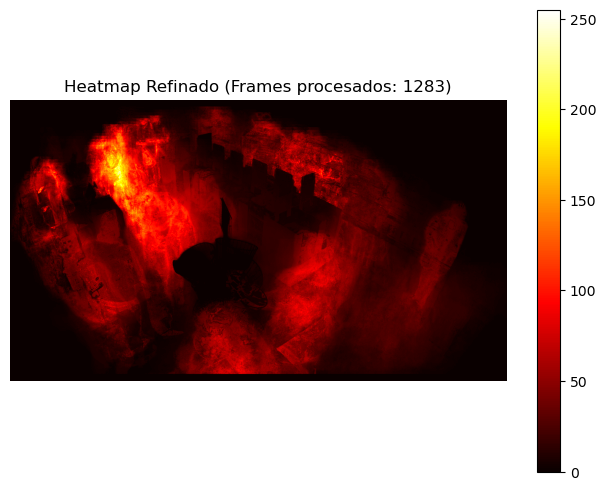

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Abrir el video con verificación de errores
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise IOError(f"No se pudo abrir el video: {video_path}")

# Crear sustractor de fondo
bg_subtractor = cv2.createBackgroundSubtractorMOG2(
    history=500,
    varThreshold=16,
    detectShadows=True
)

# Inicializar heatmap_refined como None
heatmap_refined = None
frame_count = 0  # Contador de frames procesados

# Cargar el modelo YOLO (usa el modelo correcto para tu versión de ultralytics)
model = YOLO("yolov8n-seg.pt")  # Asegúrate de tener este modelo descargado

while True:
    ret, frame = cap.read()
    if not ret:
        break  # Salir del bucle si no hay más frames

    frame_count += 1  # Incrementar el contador

    # Inicializar el acumulador del heatmap en el primer frame
    if heatmap_refined is None:
        heatmap_refined = np.zeros(frame.shape[:2], dtype=np.float32)

    # --- Paso 1: Sustracción de Fondo ---
    fgmask = bg_subtractor.apply(frame)
    _, fgmask = cv2.threshold(fgmask, 200, 255, cv2.THRESH_BINARY)

    # --- Paso 2: Segmentación con YOLO ---
    results = model(frame, verbose=False)[0]

    # Crear una máscara vacía para acumular las segmentaciones de la clase "persona"
    segmentation_mask = np.zeros(frame.shape[:2], dtype=np.uint8)

    if results.masks is not None:
        masks = results.masks.data.cpu().numpy()
        classes = results.boxes.cls.cpu().numpy()

        for mask, cls in zip(masks, classes):
            if int(cls) == 0:  # Clase "persona" en COCO
                mask_bin = (mask > 0.5).astype(np.uint8) * 255
                mask_bin_resized = cv2.resize(mask_bin, 
                                            (segmentation_mask.shape[1], segmentation_mask.shape[0]), 
                                            interpolation=cv2.INTER_NEAREST)
                segmentation_mask = cv2.bitwise_or(segmentation_mask, mask_bin_resized)

    # --- Paso 3: Combinación de Máscaras ---
    refined_mask = cv2.bitwise_and(fgmask, segmentation_mask)

    # Acumulamos la máscara refinada en el heatmap
    heatmap_refined = cv2.add(heatmap_refined, refined_mask.astype(np.float32))

# Cerrar el video
cap.release()

# Verificar si se procesaron frames
if frame_count == 0:
    print(f"Error: No se procesó ningún frame del video. Verifica:")
    print(f"1. Que la ruta '{video_path}' es correcta")
    print(f"2. Que el video no está corrupto")
    print(f"3. Que tienes los codecs necesarios instalados")
elif heatmap_refined is not None:
    # Asegurarse de que heatmap_refined es un array numpy de tipo float
    heatmap_refined = np.asarray(heatmap_refined, dtype=np.float32)
    
    # Normalizar el heatmap para visualización
    heatmap_normalized = cv2.normalize(heatmap_refined, None, 0, 255, cv2.NORM_MINMAX)
    
    # Visualización final del heatmap refinado
    plt.figure(figsize=(8,6))
    plt.imshow(heatmap_normalized, cmap='hot')
    plt.title(f"Heatmap Refinado (Frames procesados: {frame_count})")
    plt.axis('off')
    plt.colorbar()
    plt.show()
else:
    print("Error: El heatmap no se creó correctamente.")

**Heatmap normalizado**

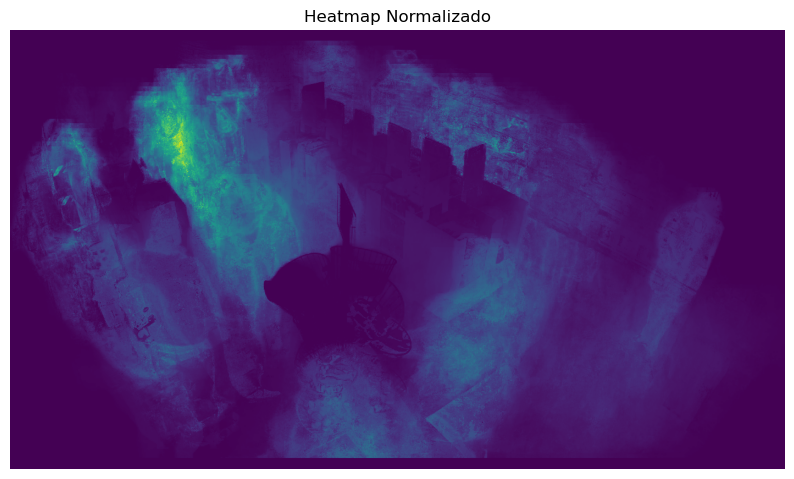

In [20]:
# Normalizar el heatmap a rango 0-255
heatmap_norm = cv2.normalize(heatmap_refined, None, 0, 255, cv2.NORM_MINMAX)
heatmap_norm = np.uint8(heatmap_norm)

# Aplicar un colormap (por ejemplo, COLORMAP_VIRIDIS)
colored_heatmap = cv2.applyColorMap(heatmap_norm, cv2.COLORMAP_VIRIDIS)

# Visualización con matplotlib
plt.figure(figsize=(10,8))
plt.imshow(cv2.cvtColor(colored_heatmap, cv2.COLOR_BGR2RGB))
plt.title("Heatmap Normalizado")
plt.axis("off")
plt.show()